In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import simpleaudio as sa


In [24]:
volume = 0.5     # range [0.0, 1.0]
fs = 44100       # sampling rate, Hz, must be integer
duration = 2.0   # in seconds, may be float
f = 440.0        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
x = np.arange(fs*duration)
samples = (np.sin(2*np.pi*x*f/fs)).astype(np.float32)
clean_audio = samples
noise = np.sin(2*np.pi*x*(f*3)/fs).astype(np.float32) * np.random.rand(len(x))
dirty_audio = samples + noise*.2

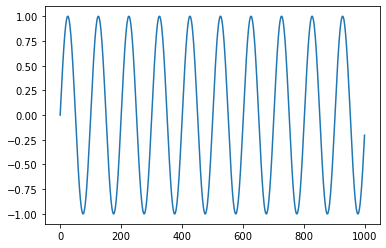

In [25]:
plt.plot(samples[:1000])
plt.show()

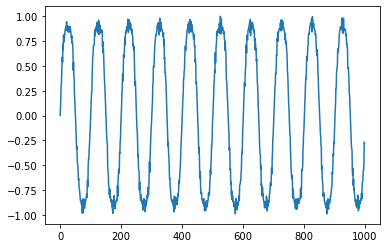

In [26]:
plt.plot(dirty_audio[:1000])
plt.show()

In [27]:

audio = (np.array(samples)*32767).astype(np.int16)#data[10000:200000, 0].astype(np.int16)


In [28]:
audio[:10]

array([    0,  2052,  4097,  6126,  8130, 10103, 12036, 13921, 15752,
       17521], dtype=int16)

In [29]:
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

In [30]:
target = dirty_audio
normalization = 32767 / np.max(np.abs(target))
audio = (np.array(target)*normalization).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, fs)
play_obj.wait_done()

In [31]:
samplesize = 50

In [32]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

In [33]:
y = getSamplesFromFile(clean_audio, samplesize)
x = getSamplesFromFile(dirty_audio, samplesize)
val_start = int(len(x)*.9)
X_train,X_valid = x[:val_start],x[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]

In [34]:
X_train.shape

(1587, 50, 1)

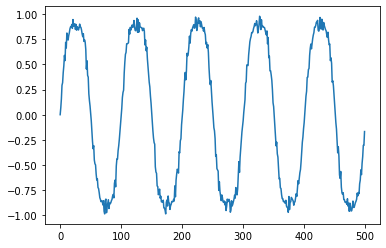

In [35]:
plt.plot(X_train[0:10].reshape(-1))
plt.show()

In [92]:
model = keras.models.Sequential([
    keras.layers.LSTM(samplesize*2, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(samplesize, return_sequences=True, input_shape=[None, 1]),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0391 - last_time_step_mse: 0.0336 - val_loss: 0.0087 - val_last_time_step_mse: 0.0032
Epoch 2/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0064 - last_time_step_mse: 0.0029 - val_loss: 0.0031 - val_last_time_step_mse: 6.7511e-04
Epoch 3/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0033 - last_time_step_mse: 0.0015 - val_loss: 0.0031 - val_last_time_step_mse: 8.9414e-04
Epoch 4/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0024 - last_time_step_mse: 0.0015 - val_loss: 0.0017 - val_last_time_step_mse: 5.9845e-04
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0019 - last_time_step_mse: 0.0013 - val_loss: 0.0018 - val_last_time_step_mse: 7.0696e-04
Epoch 6/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0017 - last_time_step_mse: 0.0012 - val_loss: 0.0021 - val_last_time_step_mse: 6.1232e-04
Epoch 7/20
50/50 [=

In [93]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, None, 100)         40800     
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 50)          30200     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1)           51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [94]:
audio_out = [0]*len(clean_audio)

In [95]:
predicted = model.predict(X_valid)

In [96]:
predicted.shape

(177, 50, 1)

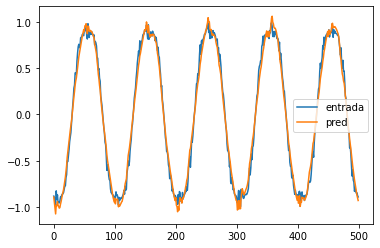

In [97]:
plt.plot(X_valid[0:10].reshape(-1), label="entrada")
plt.plot(predicted[0:10].reshape(-1), label="pred")
plt.legend()
plt.show()

In [98]:
normalization = 32767 / np.max(np.abs(X_valid))
audio = (X_valid.reshape(-1)*normalization).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, fs)
play_obj.wait_done()

In [99]:
normalization = 32767 / np.max(np.abs(predicted))
audio = (predicted.reshape(-1)*normalization).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, fs)
play_obj.wait_done()

In [22]:
len(audio)

88200